# assignment_1a question 5

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 5: Optimal Number of Layers](#optimal_number_of_layers)
    * [Optimal 3-Layer Model](#optimal_3_layer_model)
        * [Model Parameters](#model_parameters_3)
        * [Create the Model](#create_the_model_3)
        * [Run the Model](#run_the_model_3)
    * [Given 4-Layer Model](#given_4_layer_model)
        * [Model Parameters](#model_parameters_4)
        * [Create the Model](#create_the_model_4)
        * [Run the Model](#run_the_model_4)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Try Test Set](#try_test_set)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import time

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

cv_5fold = KFold(n_splits=5, random_state=seed)
cv_5fold.get_n_splits(X_train)

# data objects
histories = {} 

C:\Users\user\anaconda3\envs\cz4042_env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [4]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [5]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### plot_history_object()

In [6]:
def plot_history_object(histories, model_name, history_object, plot_val=True):    
    plt.plot(histories[model_name][history_object], label='train_'+history_object)
    
    if plot_val:
        plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    
    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

### TestCallback()

In [7]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy, sparse_categorical_crossentropy = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['accuracy'].append(accuracy)
        histories_test['test_values']['loss'].append(loss)
        histories_test['test_values']['sparse_categorical_crossentropy'].append(sparse_categorical_crossentropy)

### TimeHistory()

In [8]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Question 5: Optimal Number of Layers  <a name="optimal_number_of_layers"></a>
[Back to top](#toc)

<i>5. After you are done with the 3-layer network, design a 4-layer network with two hiddenlayers, each consisting 10 neurons, and train it with a batch size of 32 and decay parameter 10-6.

* a) Plot the train and test accuracy of the 4-layer network.
* b) Compare and comment on the performances of the optimal 3-layer and 4-layer networks.</i>

## Optimal 3-Layer Model <a name="optimal_3_layer_model"></a> 
[Back to top](#toc)

### Model Parameters <a name="model_parameters_3"></a> 
[Back to top](#toc)

In [9]:
num_neurons = 10 # from assignment_1a_q3
num_classes = 3

weight_decay_parameter = 10e-6 # from assignment_1a q4
regularization = keras.regularizers.l2(weight_decay_parameter) # from assignment_1a q4

learning_rate= 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy', keras.metrics.SparseCategoricalCrossentropy(from_logits=False)]

validation_split = 0.3
epochs = 450 # from assignment_1a_q1
batch_size = 16 # from assignment_1a_q2

callbacks = [TqdmCallback(verbose=1)]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model_3"></a> 
[Back to top](#toc)

In [10]:
def create_model_3_layer_optimal(num_neurons, num_classes, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model


In [11]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model_3"></a> 
[Back to top](#toc)

In [12]:
model = create_model_3_layer_optimal(num_neurons, num_classes, regularization, optimizer, loss, metrics)
model_name = "3_layer_optimal"

# create a new time_callback for every run
callbacks = [TqdmCallback(verbose=1)]

model_3_layer_optimal, histories[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

Model created


Training  3_layer_optimal




## Given 4-Layer Model <a name="given_4_layer_model"></a> 
[Back to top](#toc)

### Model Parameters <a name="model_parameters_4"></a> 
[Back to top](#toc)

In [13]:
num_neurons = 10 # given
num_classes = 3

weight_decay_parameter = 10e-6 # given
regularization = keras.regularizers.l2(weight_decay_parameter) # given

learning_rate= 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy', keras.metrics.SparseCategoricalCrossentropy(from_logits=False)]

validation_split = 0.3
epochs = 450 # from assignment_1a_q1
batch_size = 32 # given

callbacks = [TqdmCallback(verbose=1)]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model_4"></a> 
[Back to top](#toc)

In [14]:
def create_model_4_layer_given(num_neurons, num_classes, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [15]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=0.3,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model_4"></a> 
[Back to top](#toc)

In [16]:
model = create_model_4_layer_given(num_neurons, num_classes, regularization, optimizer, loss, metrics)
model_name = "4_layer_given"

# create a new time_callback for every run
callbacks = [TqdmCallback(verbose=1)]

model_4_layer_given, histories[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

Model created


Training  4_layer_given




### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [17]:
histories_saver(histories, "data/q5_histories.json")

histories = histories_loader("data/q5_histories.json")

Histories saved
Histories loaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

Model:  3_layer_optimal


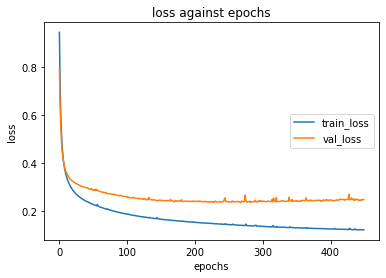

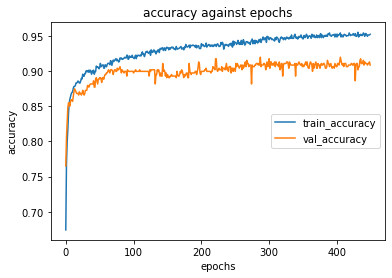

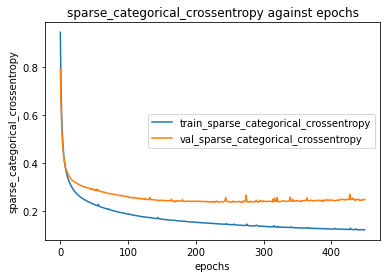

Model:  4_layer_given


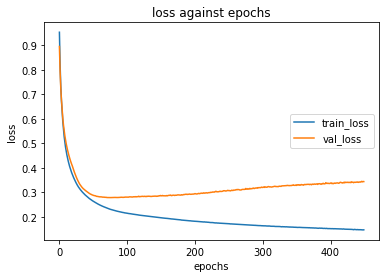

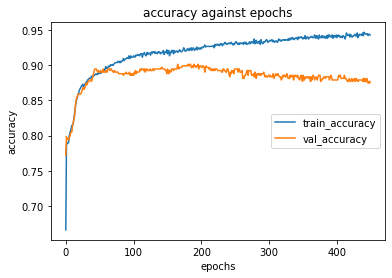

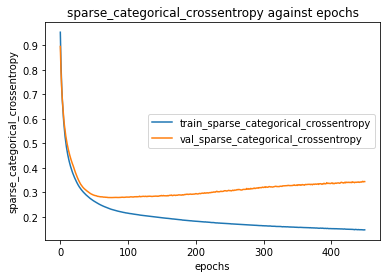

In [18]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
        plot_history_object(histories, model_name, history_object)

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

> Optimal 3-layer network model has a more stable performance than the 4-layer model, as evidenced from the increasing validation loss


### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall check the performance of the model on the test set

##### 3-layer test set

In [19]:
num_neurons = 10 # from assignment_1a_q3

weight_decay_parameter = 10e-6 # from assignment_1a q4
regularization = keras.regularizers.l2(weight_decay_parameter) # from assignment_1a q4

batch_size = 16 # from assignment_1a_q2

# the optimized parameter and custome callback
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test, Y_test)] 

print("Model Parameters set")



# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'accuracy': [],
        'sparse_categorical_crossentropy': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_3 = {}

Model Parameters set


In [21]:
model = create_model_3_layer_optimal(num_neurons, num_classes, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_convergence_test, histories_final_3[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_3, "data/q5_histories_final_3.json")
histories_final_3 = histories_loader("data/q5_histories_final_3.json")

histories_final_3['test_values'] = histories_test['test_values']

histories_saver(histories_final_3, "data/q5_histories_final_3.json", already_json=True)
histories_final_3 = histories_loader("data/q5_histories_final_3.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


##### 4-layer test set

In [22]:
num_neurons = 10 # given

weight_decay_parameter = 10e-6 # given
regularization = keras.regularizers.l2(weight_decay_parameter) # given

batch_size = 32 # given

# the optimized parameter and custome callback
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test, Y_test)] 

print("Model Parameters set")



# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'accuracy': [],
        'sparse_categorical_crossentropy': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final_4 = {}

Model Parameters set


In [23]:
model = create_model_4_layer_given(num_neurons, num_classes, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_convergence_test, histories_final_4[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final_4, "data/q5_histories_final_4.json")
histories_final_4 = histories_loader("data/q5_histories_final_4.json")

histories_final_4['test_values'] = histories_test['test_values']

histories_saver(histories_final_4, "data/q5_histories_final_4.json", already_json=True)
histories_final_4 = histories_loader("data/q5_histories_final_4.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


> ### a) Plot the train and test accuracy of the 3-layer network

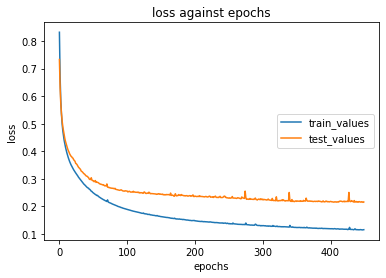

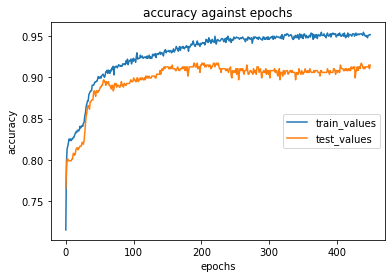

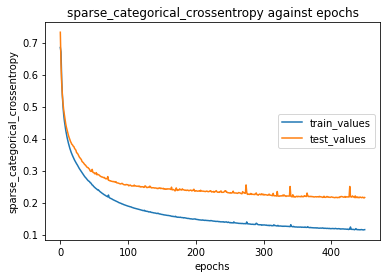

In [24]:
for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
    for model_name in histories_final_3.keys():
        plt.plot(histories_final_3[model_name][history_object], label=model_name)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

> ### a) Plot the train and test accuracy of the 4-layer network

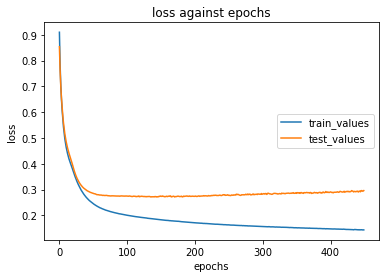

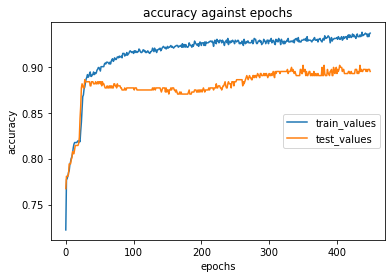

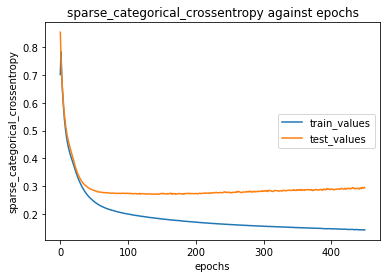

In [25]:
for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
    for model_name in histories_final_4.keys():
        plt.plot(histories_final_4[model_name][history_object], label=model_name)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

In [31]:
histories_final_4.keys()

dict_keys(['train_values', 'test_values'])

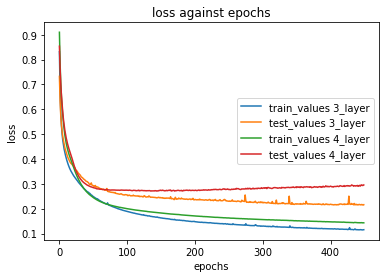

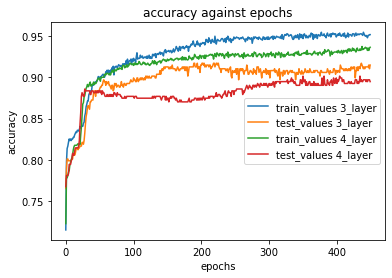

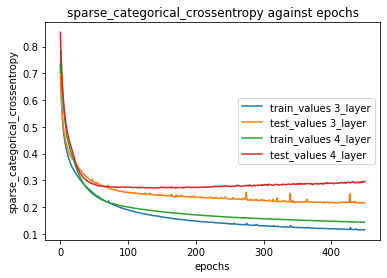

In [32]:
for history_object in ['loss', 'accuracy', 'sparse_categorical_crossentropy']:
    plt.plot(histories_final_3['train_values'][history_object], label='train_values 3_layer')
    plt.plot(histories_final_3['test_values'][history_object], label='test_values 3_layer')
    plt.plot(histories_final_4['train_values'][history_object], label='train_values 4_layer')
    plt.plot(histories_final_4['test_values'][history_object], label='test_values 4_layer')

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> ```3-layer optimal``` is better than the specified 4-layer network

It's train and test accuracies are higher than the 4-layer network, and the losses are also lower 